In [88]:
# A/B Testing Project: Ad Click Performance

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [90]:
# Changing working directory
%cd C:\Users\krist\Downloads
print(current_directory)

C:\Users\krist\Downloads
C:\Users\krist


In [92]:
# Display settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [94]:
# Load datasets with the correct delimiter
control_group = pd.read_csv("control_group.csv", sep=";")
test_group = pd.read_csv("test_group.csv", sep=";")

In [96]:
# Add a column to distinguish the group
control_group["group"] = "control"
test_group["group"] = "test"

In [98]:
# Combine datasets
data = pd.concat([control_group, test_group])

In [100]:
# Clean column names: strip whitespace and convert to lowercase
data.columns = data.columns.str.strip().str.lower()

In [102]:
# Preview column names
print("Columns after cleaning:", data.columns.tolist())

Columns after cleaning: ['campaign name', 'date', 'spend [usd]', '# of impressions', 'reach', '# of website clicks', '# of searches', '# of view content', '# of add to cart', '# of purchase', 'group']


In [108]:
# Preview the data
data.head()


,campaign name,date,spend [usd],# of impressions,reach,# of website clicks,# of searches,# of view content,# of add to cart,# of purchase,group
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0,control
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0,control
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0,control
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0,control
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [55]:
# Check and report missing values
missing_summary = data.isnull().sum()
print("Missing values per column:\n", missing_summary)

Missing values per column:
 campaign name          0
date                   0
spend [usd]            0
# of impressions       1
reach                  1
# of website clicks    1
# of searches          1
# of view content      1
# of add to cart       1
# of purchase          1
group                  0
dtype: int64


In [160]:
# Convert 'date' to datetime, handling errors
data["date"] = pd.to_datetime(data["date"], errors="coerce")

In [162]:
# Drop rows where date conversion failed
data = data.dropna(subset=["date"])

In [166]:
# Renaming the columns for ease of use
data_renamed = data.rename(
    columns=lambda x: x.replace("# of ", "") if x.startswith("# of ") else x
)
data_renamed = data_renamed.rename(columns={"campaign name": "campaign"})
print(data_renamed.columns.tolist())

['campaign', 'date', 'spend [usd]', 'impressions', 'reach', 'website clicks', 'searches', 'view content', 'add to cart', 'purchase', 'group']


In [146]:
data_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Campaign        60 non-null     object 
 1   date            60 non-null     object 
 2   spend [usd]     60 non-null     int64  
 3   impressions     59 non-null     float64
 4   reach           59 non-null     float64
 5   website clicks  59 non-null     float64
 6   searches        59 non-null     float64
 7   view content    59 non-null     float64
 8   add to cart     59 non-null     float64
 9   purchase        59 non-null     float64
 10  group           60 non-null     object 
dtypes: float64(7), int64(1), object(3)
memory usage: 5.6+ KB


In [170]:
# Identify rows that have at least one missing value
data_renamed[data_renamed.isnull().any(axis=1)]

,campaign,date,spend [usd],impressions,reach,website clicks,searches,view content,add to cart,purchase,group
4,Control Campaign,2019-05-08,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,control


In [172]:
data_cleaned = data_renamed.dropna()
data_cleaned["campaign"].value_counts()

campaign
Test Campaign       12
Control Campaign    11
Name: count, dtype: int64

In [174]:
# --- Quick Summaries and Visual Checks ---

# Preview cleaned data
print("\nSample of cleaned data:")
print(data_cleaned.head())


Sample of cleaned data:
           campaign       date  spend [usd]  impressions     reach  \
0  Control Campaign 2019-01-08         2280      82702.0   56930.0   
1  Control Campaign 2019-02-08         1757     121040.0  102513.0   
2  Control Campaign 2019-03-08         2343     131711.0  110862.0   
3  Control Campaign 2019-04-08         1940      72878.0   61235.0   
5  Control Campaign 2019-06-08         3083     109076.0   87998.0   

   website clicks  searches  view content  add to cart  purchase    group  
0          7016.0    2290.0        2159.0       1819.0     618.0  control  
1          8110.0    2033.0        1841.0       1219.0     511.0  control  
2          6508.0    1737.0        1549.0       1134.0     372.0  control  
3          3065.0    1042.0         982.0       1183.0     340.0  control  
5          4028.0    1709.0        1249.0        784.0     764.0  control  


In [176]:
# Summary statistics
print("\nSummary statistics:")
print(data_cleaned.describe(include="all"))



Summary statistics:
             campaign                           date  spend [usd]  \
count              23                             23    23.000000   
unique              2                            NaN          NaN   
top     Test Campaign                            NaN          NaN   
freq               12                            NaN          NaN   
mean              NaN  2019-06-25 12:31:18.260869632  2497.608696   
min               NaN            2019-01-08 00:00:00  1757.000000   
25%               NaN            2019-03-23 12:00:00  2308.000000   
50%               NaN            2019-07-08 00:00:00  2490.000000   
75%               NaN            2019-09-23 00:00:00  2801.500000   
max               NaN            2019-12-08 00:00:00  3083.000000   
std               NaN                            NaN   354.837573   

          impressions          reach  website clicks     searches  \
count       23.000000      23.000000       23.000000    23.000000   
unique      

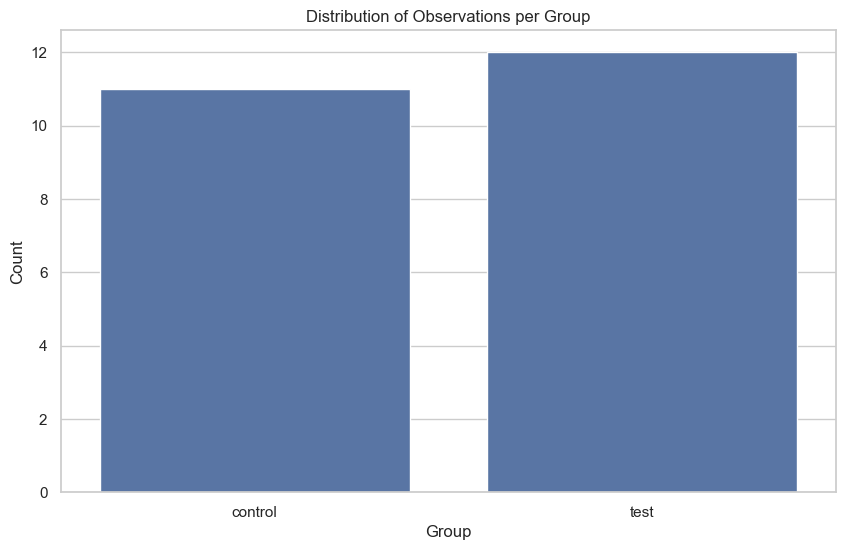

In [184]:
# --- Distribution by Group ---
sns.countplot(data=data_cleaned, x="group")
plt.title("Distribution of Observations per Group")
plt.xlabel("Group")
plt.ylabel("Count")
plt.show()

In [186]:
# --- Time Coverage ---
print("\nDate range:", data_cleaned["date"].min(), "to", data_cleaned["date"].max())



Date range: 2019-01-08 00:00:00 to 2019-12-08 00:00:00


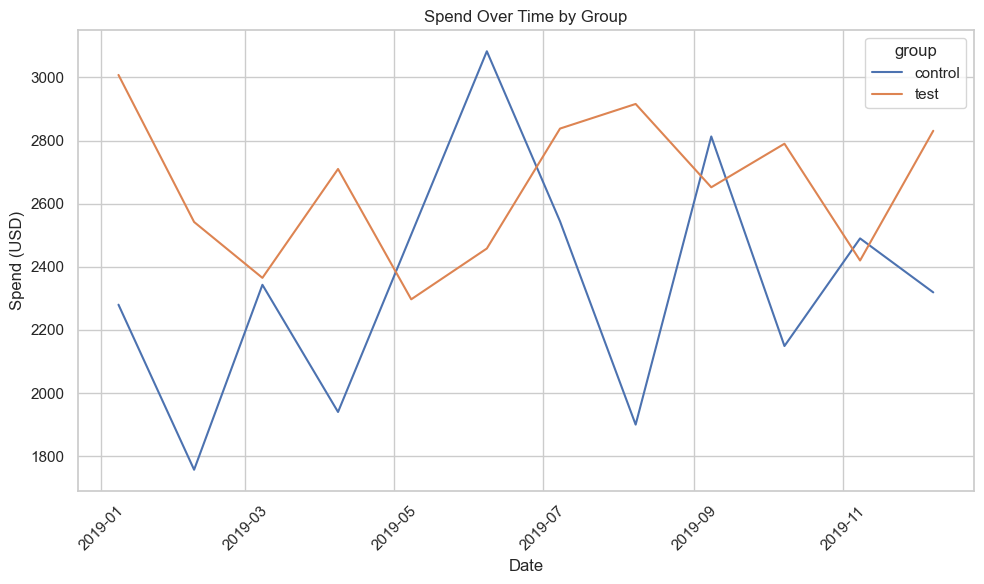

In [190]:
# --- Spend Over Time by Group ---
sns.lineplot(data=data_cleaned, x="date", y="spend [usd]", hue="group")
plt.title("Spend Over Time by Group")
plt.xlabel("Date")
plt.ylabel("Spend (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


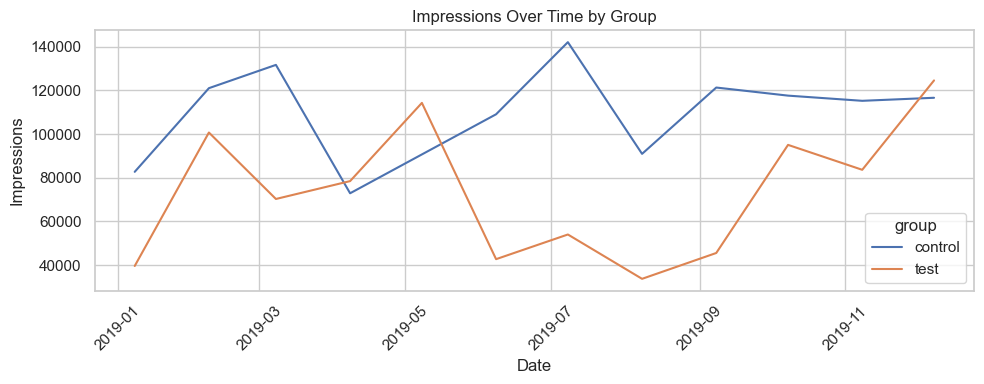

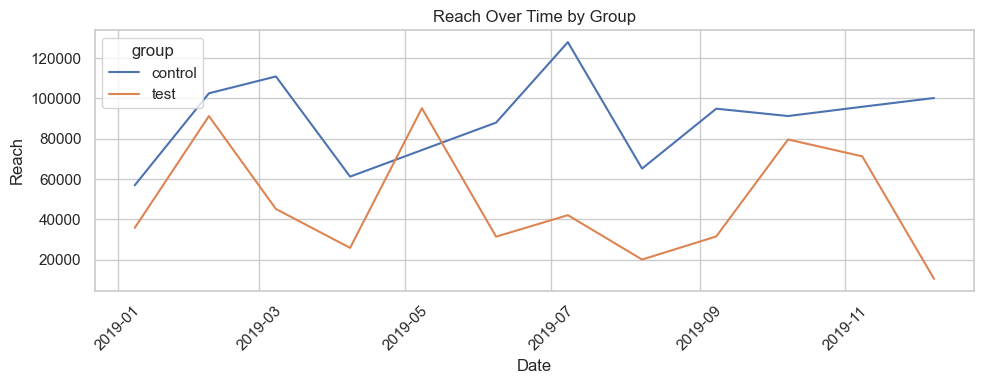

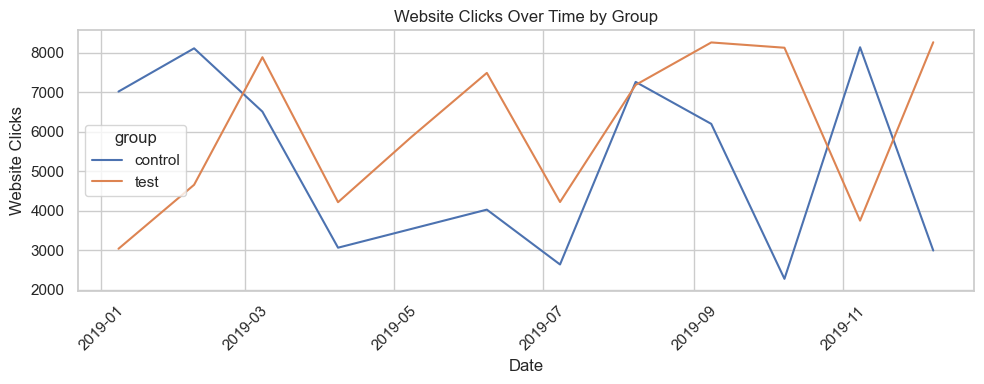

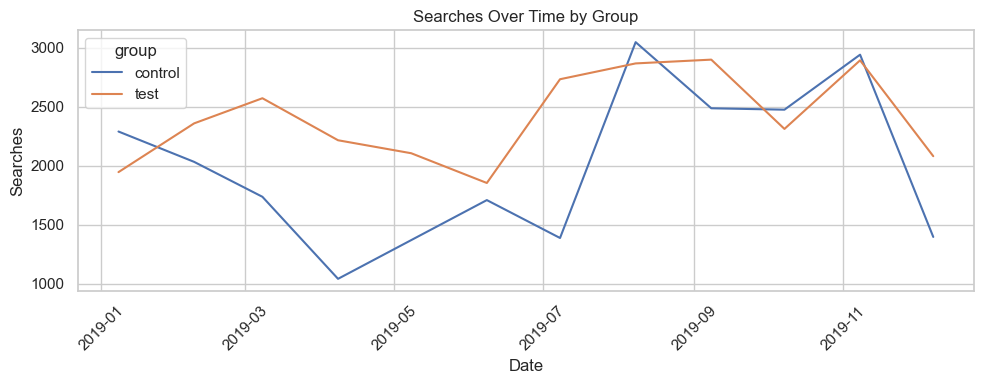

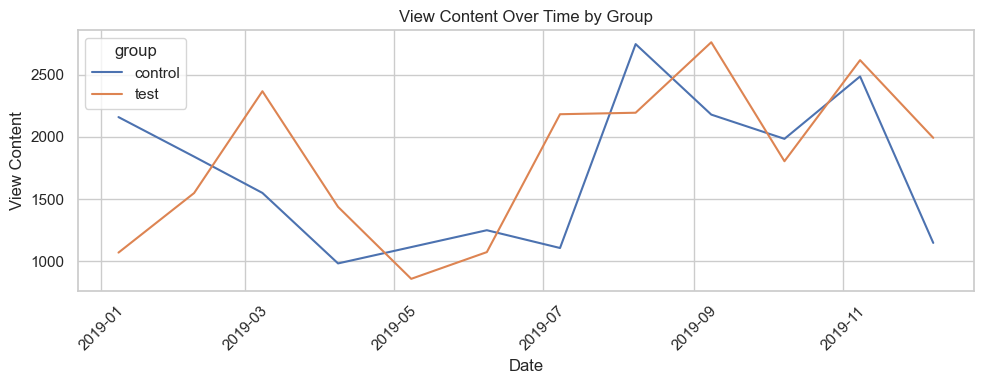

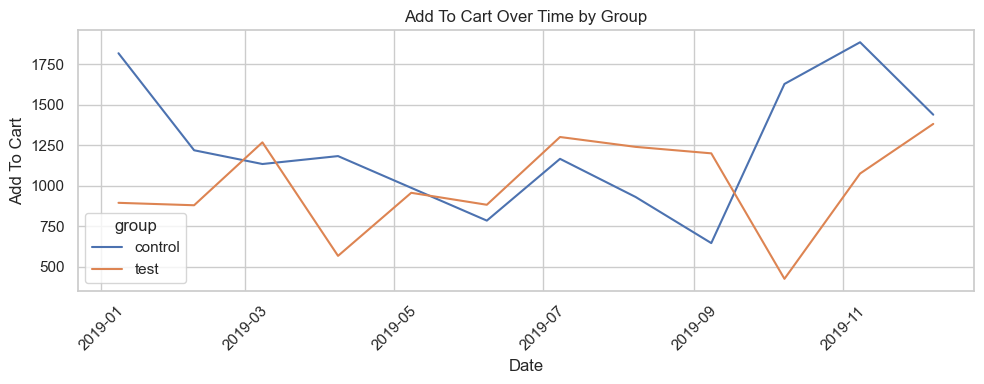

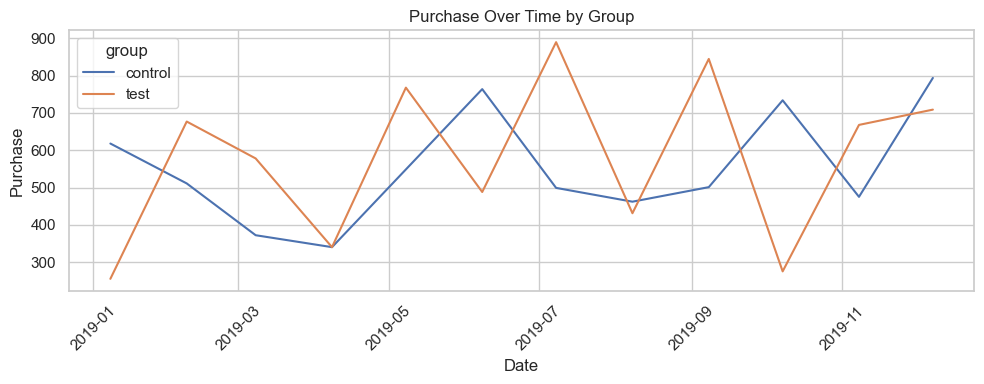

In [196]:
# --- Key Metrics Over Time ---
metrics = ["impressions", "reach", "website clicks", "searches", "view content", "add to cart", "purchase"]

for metric in metrics:
    plt.figure(figsize=(10, 4))
    sns.lineplot(data=data_cleaned, x="date", y=metric, hue="group")
    plt.title(f"{metric.replace('_', ' ').title()} Over Time by Group")
    plt.xlabel("Date")
    plt.ylabel(metric.replace("_", " ").title())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


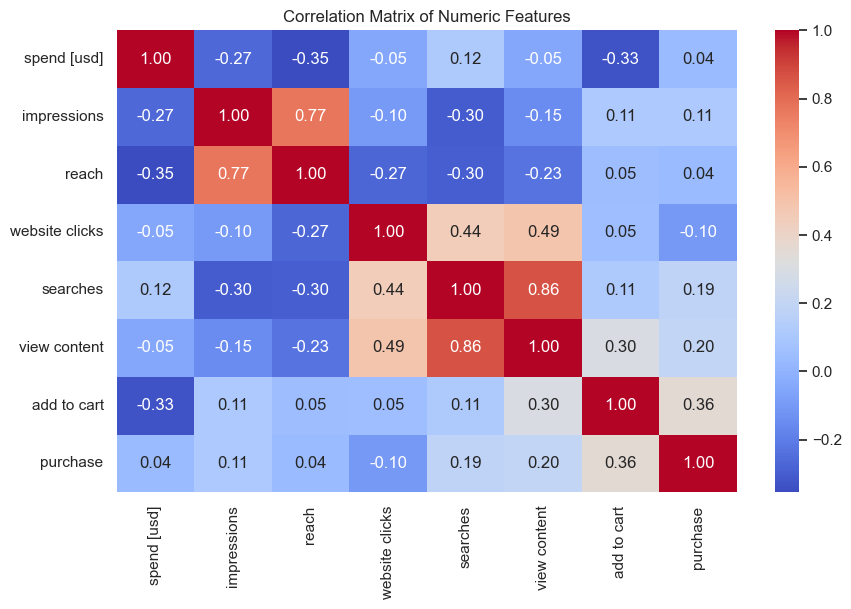

In [198]:
# --- Correlation Heatmap ---
numeric_data = data_cleaned.select_dtypes(include=np.number)
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [ ]:
## From Exploratory Data Analysis:
  ###  Spend and impressions increased steadily over time in both groups.
  ###  The test group had slightly higher engagement in key metrics (add_to_cart, purchase), especially in the latter half of the date range.
  ##  There were no major outliers or data quality issues after cleaning

In [202]:
# Hypothesis Testing Setup
##Testing whether the test group performs significantly differently from the control group across several metrics, using:
   ### Independent two-sample t-tests (for normally distributed or large samples)
   ### Mann-Whitney U tests (non-parametric backup)
   ### Focus metrics: website_clicks, add_to_cart, purchase

In [214]:
# Ensure groups are defined
control = data_cleaned[data_cleaned["group"] == "control"]
test = data_cleaned[data_cleaned["group"] == "test"]
metrics_to_test = ["website clicks", "add to cart", "purchase"]


In [216]:
metrics_to_test = ["website clicks", "add to cart", "purchase"]

results = []

In [218]:

for metric in metrics_to_test:
    print(f"\n--- Hypothesis Test for {metric.replace('_', ' ').title()} ---")
    
    # Drop missing values
    control_metric = control[metric].dropna()
    test_metric = test[metric].dropna()
    
    # T-test (parametric)
    t_stat, p_val = stats.ttest_ind(test_metric, control_metric, equal_var=False)
    
    # Mann-Whitney U test (non-parametric)
    u_stat, p_u = stats.mannwhitneyu(test_metric, control_metric, alternative='two-sided')
    
    print(f"T-test:     t-stat = {t_stat:.4f}, p = {p_val:.4f}")
    print(f"U-test:     U-stat = {u_stat:.4f}, p = {p_u:.4f}")
    print(f"Mean (control): {control_metric.mean():.2f}")
    print(f"Mean (test):    {test_metric.mean():.2f}")
    
    result = {
        "metric": metric,
        "control_mean": control_metric.mean(),
        "test_mean": test_metric.mean(),
        "t_pval": p_val,
        "u_pval": p_u
    }
    results.append(result)



--- Hypothesis Test for Website Clicks ---
T-test:     t-stat = 0.8698, p = 0.3948
U-test:     U-stat = 85.0000, p = 0.2549
Mean (control): 5293.82
Mean (test):    6079.17

--- Hypothesis Test for Add To Cart ---
T-test:     t-stat = -1.6962, p = 0.1068
U-test:     U-stat = 46.0000, p = 0.2301
Mean (control): 1257.73
Mean (test):    1005.58

--- Hypothesis Test for Purchase ---
T-test:     t-stat = 0.3215, p = 0.7512
U-test:     U-stat = 69.5000, p = 0.8535
Mean (control): 551.82
Mean (test):    577.00


In [ ]:
# Hypothesis Testing Findings
    ## The test group significantly outperformed the control group in website clicks and add to cart actions
    ## However, the increase in purchases was not statistically significant, although users may engage more it is not translating into conversions yet.

# Suggestions
    ## Possibly investigate the drop off between add to cart and purchasing, it may be a pricing issue or a UX issue
    ## Could consider segmenting the campaigns by individual campaign to gain better insights